## Spotify Project
This project is supposed to help you understand how you can use python to aggregate data into a usable format for simple machine learning. 

The end goal is to build a program to aggregate Spotify song data using api calls and web scraping, then perform some machine learning on that data.

Topics covered:
* HTTP requests
* Web scraping with Selenuim
* data manipulation with pandas
* data modeling with sklearn

### Key Points
In order to call Spotify's api, we need an access token. Spotify has documentation on how to do this, but simply speaking, we make an API call to a link that spotify provides and our token is returned(need to register an app with spotify first to gain the client ID and client secret). 

After we get the token, we can call most of spotify's API endpoints(we have a basic scope credential, which is beyond this project). We want to get information on songs, but the API endpoint for song information only takes a song id. How do we get the song id?

The only way to get a song's id is to use the 'search' API endpoint. This can take many parameters but we will be giving it song name and artist. The response we get will have that songs ID that we can use to get more information on that song.

Once we a way to get a song's ID based off of name and artist. We need a list of songs with their names and artists. This is where web scraping will come into play. Spotify has a list of weekly top songs and we can pull the song names and artists off of that and save them in a list.

After all this, we have what we need to build our data. The steps are as follows:

#### Steps:
1. get a token
2. get a list of songs using selenium to web scrape song name and artist
3. get the IDs of each song in our list using the search API
4. call the API endpoint for song data for each song(with ID) and save data in a list
5. turn the list generated from step 4 into a dataframe
6. celebrate cause the boring stuff is over

In [231]:
import requests as rq # tool to make api calls
import pandas as pd # data processing
import base64 # to encoded the credentials for api calls
import json # for responses to api calls
from urllib.parse import quote # for url encoding
from datetime import datetime, timedelta # constructing urls
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [236]:
url = 'https://accounts.spotify.com/api/token' # api call to recieve token
clientID = '67158a9f3e804254bfe2e64fb370b549' # app id that is created with spotify 
clientS = '87bd1c49c81448e499d58825bc40e8c4' # secret for app that is registered

In [237]:
# need to get a token from spotify to validate our api calls
# much easier to create a function to do this, since we may be 
# using this often
import base64
def get_token(clientID,clientS,url):
    newS = clientID + ':' + clientS
    newS = base64.b64encode(newS.encode("utf-8"))
    newS64 = str(newS, "utf-8")
    data = {
        'grant_type' : 'client_credentials'
    }
    headers = {
        'Authorization' : 'Basic ' + newS64
    }
    resp = rq.post(url,headers=headers, data=data)
    token = resp.json()['access_token']
    return(token)

In [238]:
token = get_token(clientID,clientS,url)
token

ConnectionError: HTTPSConnectionPool(host='accounts.spotify.com', port=443): Max retries exceeded with url: /api/token (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f49a7a4c240>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [ ]:
# In order to get song information, we need to obtain a song id
# this is only done by using spotify's search api, let's create
# a function to search a song with spotify's api and return the id
# of that song
def get_song_id(songName,artist,token):
    songNameQuote = quote(songName)
    artistQuote = quote(artist)#create the encoded song name
    url2 = 'https://api.spotify.com/v1/search?q={}%20artist:{}&type=track'.format(songNameQuote,artistQuote) # use api to search for song
    print(url2)
    headers = {
        'Authorization' : 'Bearer '+token
    }
    resp = rq.get(url2,headers=headers) # use search api in spotify to find song ID
    info = resp.json()
    items = info['tracks']['items'] # get all the responses, then iterate through them
    id = ''
    for el in items:
        if(el['name'] == songName):
            id = el['uri'].split(':')[-1]
            break
    return(id) # return the id of the song to use in api calls

In [ ]:
songID = get_song_id("Circles","Post Malone",token)
songID

### Next Steps
We now have a way to use spotify's api and find id of songs based off of their names. This is great, what do you think would be the next step?

In [ ]:
from selenium import webdriver
import chromedriver_binary

In [ ]:
def get_all_songs(webEL):
    songsList = []
    for el in webEL:
        tempEl = el.get_attribute('innerHTML')
        tempEl = tempEl.split('>')
        if(len(tempEl) > 2):
            songName = tempEl[1].split('<')[0]
            artist = tempEl[3].split('<')[0][3:]
            songsList.append([songName,artist])
    return(songsList)

In [ ]:
def get_page_songs():
    allSongs = []
    d = datetime.today() - timedelta(days=3)
    driver = webdriver.Chrome()
    for i in range(20):
        d,dateRangeString =  construct_date_string(d)
        driver.get('https://spotifycharts.com/regional/us/weekly/'+dateRangeString)
        songNames = driver.find_elements_by_class_name("chart-table-track");
        songName = get_all_songs(songNames)
        allSongs.extend(songName)
    return(allSongs)

In [ ]:
def construct_date_string(endDate):
    startDate = endDate - timedelta(days=7)
    endString = datetime.strftime(endDate,"%Y-%m-%d")
    startString = datetime.strftime(startDate,"%Y-%m-%d")
    finalString = startString + '--' + endString
    return(startDate,finalString)

In [ ]:
def build_data(all_songs,token):
        keys = ['Song Name','Artist']
        url = 'https://api.spotify.com/v1/audio-features/'
        headers = {
            'Authorization' : 'Bearer '+token
        }
        for song in all_songs:
            try:
                songid = get_song_id(song[0],song[1],token)
                resp = rq.get(url = url+songid,headers=headers)
                values = list(resp.json().values())
                if(len(keys) == 2):
                    print(resp.json().keys())
                    keys.extend(resp.json().keys())
                if(len(values) != 0):
                    song.extend(values)
                else:
                    all_songs.remove(song)
            except:
                print("There was an error on song: " + song)
        allDataDF = pd.DataFrame(all_songs,columns = keys)
        return(allDataDF)

In [ ]:
#all_songs = get_page_songs()

In [239]:
#DF = build_data(all_songs,token)
#DF.dropna(inplace=True)
#DF.to_csv('allSongs.csv')
DF = pd.read_csv('allSongs.csv')

In [240]:
DF

,Unnamed: 0,Song Name,Artist,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,Circles,Post Malone,0.695,0.7620,0.0,-3.497,1.0,0.0395,0.192000,...,0.0863,0.553,120.042,audio_features,21jGcNKet2qwijlDFuPiPb,spotify:track:21jGcNKet2qwijlDFuPiPb,https://api.spotify.com/v1/tracks/21jGcNKet2qw...,https://api.spotify.com/v1/audio-analysis/21jG...,215280.0,4.0
1,1,Ransom,Lil Tecca,0.745,0.6420,7.0,-6.257,0.0,0.2870,0.020400,...,0.0658,0.226,179.974,audio_features,1lOe9qE0vR9zwWQAOk6CoO,spotify:track:1lOe9qE0vR9zwWQAOk6CoO,https://api.spotify.com/v1/tracks/1lOe9qE0vR9z...,https://api.spotify.com/v1/audio-analysis/1lOe...,131240.0,4.0
2,2,BOP,DaBaby,0.769,0.7870,11.0,-3.909,1.0,0.3670,0.189000,...,0.1290,0.836,126.770,audio_features,6Ozh9Ok6h4Oi1wUSLtBseN,spotify:track:6Ozh9Ok6h4Oi1wUSLtBseN,https://api.spotify.com/v1/tracks/6Ozh9Ok6h4Oi...,https://api.spotify.com/v1/audio-analysis/6Ozh...,159715.0,4.0
3,3,Truth Hurts,Lizzo,0.715,0.6240,4.0,-3.046,0.0,0.1140,0.110000,...,0.1230,0.412,158.087,audio_features,5qmq61DAAOUaW8AUo8xKhh,spotify:track:5qmq61DAAOUaW8AUo8xKhh,https://api.spotify.com/v1/tracks/5qmq61DAAOUa...,https://api.spotify.com/v1/audio-analysis/5qmq...,173325.0,4.0
4,4,223's (feat. 9lokknine),YNW Melly,0.931,0.5020,0.0,-9.311,0.0,0.3530,0.038900,...,0.0912,0.712,94.999,audio_features,4sjiIpEv617LDXaidKioOI,spotify:track:4sjiIpEv617LDXaidKioOI,https://api.spotify.com/v1/tracks/4sjiIpEv617L...,https://api.spotify.com/v1/audio-analysis/4sji...,176640.0,4.0
5,6,VIBEZ,DaBaby,0.768,0.6520,1.0,-2.708,0.0,0.3070,0.113000,...,0.1070,0.777,154.187,audio_features,0fySG6A6qLE8IvDpayb5bM,spotify:track:0fySG6A6qLE8IvDpayb5bM,https://api.spotify.com/v1/tracks/0fySG6A6qLE8...,https://api.spotify.com/v1/audio-analysis/0fyS...,144935.0,4.0
6,7,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,0.760,0.4790,2.0,-5.574,1.0,0.0466,0.556000,...,0.0703,0.913,89.911,audio_features,3KkXRkHbMCARz0aVfEt68P,spotify:track:3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,https://api.spotify.com/v1/audio-analysis/3KkX...,158040.0,4.0
7,8,Saint-Tropez,Post Malone,0.617,0.6840,0.0,-3.618,1.0,0.0439,0.054500,...,0.1040,0.295,132.113,audio_features,05mDaV9Vb3wrzjF6OPZnhq,spotify:track:05mDaV9Vb3wrzjF6OPZnhq,https://api.spotify.com/v1/tracks/05mDaV9Vb3wr...,https://api.spotify.com/v1/audio-analysis/05mD...,150867.0,4.0
8,9,Panini,Lil Nas X,0.703,0.5940,5.0,-6.146,0.0,0.0752,0.342000,...,0.1230,0.475,153.848,audio_features,6fTt0CH2t0mdeB2N9XFG5r,spotify:track:6fTt0CH2t0mdeB2N9XFG5r,https://api.spotify.com/v1/tracks/6fTt0CH2t0md...,https://api.spotify.com/v1/audio-analysis/6fTt...,114893.0,4.0
9,10,Hot (feat. Gunna),Young Thug,0.855,0.6510,0.0,-8.044,0.0,0.2350,0.063000,...,0.0772,0.559,111.997,audio_features,5Z8HZM6iQMhhqyPcCGY5g9,spotify:track:5Z8HZM6iQMhhqyPcCGY5g9,https://api.spotify.com/v1/tracks/5Z8HZM6iQMhh...,https://api.spotify.com/v1/audio-analysis/5Z8H...,193027.0,4.0


### Retrieving Label
In order to actually predict the popularity of the songs, the data needs a value to train on. This program will use the popularity of songs as a prediciton value. There is an API call to spotify that we can use to retrieve the popularity of those songs. It is a number between 0 and 100. After we get the popularity values of each songs, we will append the data to our existing data frame. Then we can do some machine learning!!

In [241]:
url = "https://api.spotify.com/v1/tracks/11dFghVXANMlKmJXsNCbNl"
headers = {
        'Authorization' : 'Bearer '+token
}

In [242]:
response = rq.get(url,headers=headers).json()

KeyboardInterrupt: 

In [ ]:
print('Popularity Score: ' + str(response['popularity']) + '/100')
response

In [ ]:
def get_populatity(songID):
    url = "https://api.spotify.com/v1/tracks/" + str(songID)
    headers = {
        'Authorization' : 'Bearer '+token
    }
    response = rq.get(url,headers=headers).json()
    return(response['popularity'])

In [ ]:
'''
popList = []
i = 0
for el in DF['id']:
    popList.append(get_populatity(el))
    if(i % 1000 == 0):
        print(i)
    i += 1
popList
'''

In [ ]:
#DF['Popularity'] = popList

In [243]:
#DF.to_csv('allSongsLabeled.csv')
DF = pd.read_csv('allSongsLabeled.csv')

In [244]:
columns = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']

In [251]:
# Build the new DataFrame with the values we are looking for
DF2 = DF[columns] # get the numerical columns
DF2['Popularity'] = DF['Popularity'] # slap our prediction column on the DataFrame
DF2

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Popularity
0,0.695,0.7620,0.0,-3.497,1.0,0.0395,0.192000,0.002440,0.0863,0.553,120.042,97
1,0.745,0.6420,7.0,-6.257,0.0,0.2870,0.020400,0.000000,0.0658,0.226,179.974,86
2,0.769,0.7870,11.0,-3.909,1.0,0.3670,0.189000,0.000000,0.1290,0.836,126.770,87
3,0.715,0.6240,4.0,-3.046,0.0,0.1140,0.110000,0.000000,0.1230,0.412,158.087,94
4,0.931,0.5020,0.0,-9.311,0.0,0.3530,0.038900,0.000000,0.0912,0.712,94.999,91
5,0.768,0.6520,1.0,-2.708,0.0,0.3070,0.113000,0.000000,0.1070,0.777,154.187,86
6,0.760,0.4790,2.0,-5.574,1.0,0.0466,0.556000,0.000000,0.0703,0.913,89.911,91
7,0.617,0.6840,0.0,-3.618,1.0,0.0439,0.054500,0.000000,0.1040,0.295,132.113,93
8,0.703,0.5940,5.0,-6.146,0.0,0.0752,0.342000,0.000000,0.1230,0.475,153.848,93
9,0.855,0.6510,0.0,-8.044,0.0,0.2350,0.063000,0.000000,0.0772,0.559,111.997,90


In [253]:
# split into X and y data and then split for training and testing
from sklearn.model_selection import train_test_split
X = DF2.iloc[:,:-1] # grab every column except the last, features of our model
y = DF2.iloc[:,-1] # grab the last column, labels of our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split the data for training

In [254]:
# perform a variation of Linear Regression on Data
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train,y_train)
ridge.score(X_test,y_test)

0.043853815043010114

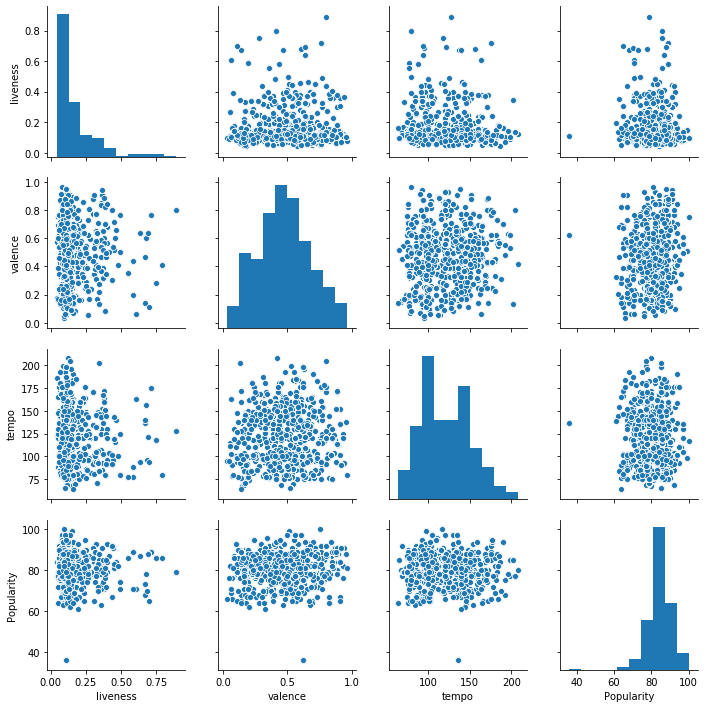

In [255]:
sns.pairplot(DF2.iloc[:,8:])

Obviously 4% accuracy is not ideal... so instead of predicting EXACT values lets see if we can manipulate our data just a bit more to turn this into a classification problem instead!!

In [256]:
print("This is the original Popularity Column: ")
print(DF2.Popularity.head())
print('-----------------------------\n')


bins = np.array([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]) # get our buckets
DF2['Popularity_bucket'] = pd.cut(DF2.Popularity, bins) # split our Popularity column into buckets


print("This is the bucketed Popularity Column: ")
print(DF2.Popularity_bucket.head())
print('------------------------------\nFull Interval: ' + str(DF2.Popularity_bucket[0]))
print('Left of Interval: '+str(DF2.Popularity_bucket[0].left))


DF2.Popularity_bucket = [el.left for el in DF2.Popularity_bucket] # grab the left of the interval


print('------------------------------\nThis is the transformed Columns: ')
print(DF2.Popularity_bucket.head())


DF2.drop('Popularity',axis=1,inplace=True) # drop our real prediction values

This is the original Popularity Column: 
0    97
1    86
2    87
3    94
4    91
Name: Popularity, dtype: int64
-----------------------------

This is the bucketed Popularity Column: 
0    (95, 100]
1     (85, 90]
2     (85, 90]
3     (90, 95]
4     (90, 95]
Name: Popularity_bucket, dtype: category
Categories (19, interval[int64]): [(5, 10] < (10, 15] < (15, 20] < (20, 25] ... (80, 85] < (85, 90] < (90, 95] < (95, 100]]
------------------------------
Full Interval: (95, 100]
Left of Interval: 95
------------------------------
This is the transformed Columns: 
0    95
1    85
2    85
3    90
4    90
Name: Popularity_bucket, dtype: int64


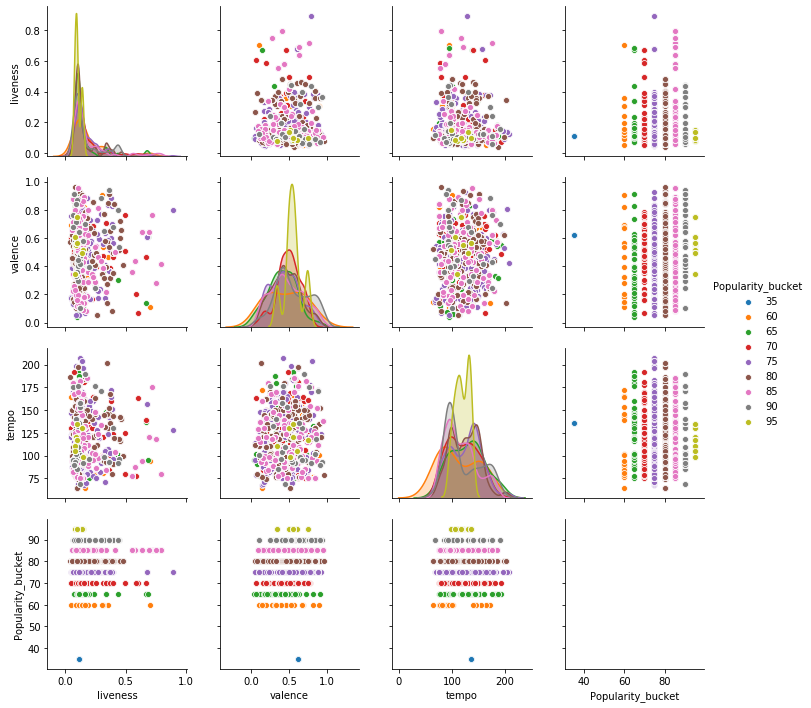

In [246]:
sns.pairplot(DF2.iloc[:,8:],hue='Popularity_bucket')

In [257]:
from sklearn.model_selection import train_test_split
X = DF2.iloc[:,:-1] # grab every column except the last
y = DF2.iloc[:,-1] # grab the last column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split the data for training

In [258]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
dtc.score(X_test,y_test)

0.9523026315789473

### FINISHED
Congrats on making it through!! You have officially done your first machine learning project!!

### Remarks

We covered a large amount of topics so if there are some things that are still shakey, that is completely fine. The thing about projects like this, is you always have to learn something new in order to complete it! If you have any questions please feel free to email me at 'samuel2@iastate.edu'! 